In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-scs/data_fold0.zip

In [3]:
ls

__notebook__.ipynb  data_fold0/


In [4]:
IMG_DIR = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

In [5]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 16
EPOCHS = 100

SAMPLE = None
CONDITIONS = ['Spinal Canal Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'

In [6]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [7]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [8]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [9]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [10]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found ' + lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)

In [11]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [12]:
label_df = {'study_id': [], 'condition': [], 'level': [], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [13]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [14]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id == study_id) & (label_df.series_id == series_id) &
                        (label_df.instance_number == instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id == study_id)]
    else:
        return label_df[(train_xy.study_id == study_id) & (label_df.series_id == series_id)]

In [15]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
    image = np.stack([image] * 3, axis=-1).astype('uint8')
    return image


def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [16]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [17]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f'{get_accronym(row['condition'])}_{row['level']}'
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255, 255,0) 
    elif row['label'] == 'Severe':
        color = (255, 0, 0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
24756,2239199413,Right Neural Foraminal Narrowing,L1/L2,Moderate,3,2322807347,13,299.984087,127.305606,Sagittal T1
24757,2239199413,Right Neural Foraminal Narrowing,L2/L3,Moderate,3,2322807347,13,285.487670,172.327793,Sagittal T1
24758,2239199413,Right Neural Foraminal Narrowing,L3/L4,Moderate,3,2322807347,13,274.730765,221.623244,Sagittal T1
24759,2239199413,Right Neural Foraminal Narrowing,L4/L5,Moderate,3,2322807347,13,261.826857,268.036004,Sagittal T1


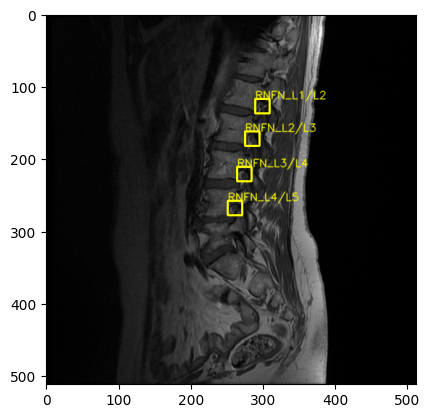

In [18]:
plt.imshow(img)
plt.show()

In [19]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
    image = np.stack([image] * 3, axis=-1).astype('uint8')
    return image

In [20]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [21]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f'{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}'
            label2id[cls_] = i
            id2label[i] = cls_
            i += 1

In [22]:
id2label

{0: 'spinal_canal_stenosis_l1_l2_normal/mild',
 1: 'spinal_canal_stenosis_l1_l2_moderate',
 2: 'spinal_canal_stenosis_l1_l2_severe',
 3: 'spinal_canal_stenosis_l2_l3_normal/mild',
 4: 'spinal_canal_stenosis_l2_l3_moderate',
 5: 'spinal_canal_stenosis_l2_l3_severe',
 6: 'spinal_canal_stenosis_l3_l4_normal/mild',
 7: 'spinal_canal_stenosis_l3_l4_moderate',
 8: 'spinal_canal_stenosis_l3_l4_severe',
 9: 'spinal_canal_stenosis_l4_l5_normal/mild',
 10: 'spinal_canal_stenosis_l4_l5_moderate',
 11: 'spinal_canal_stenosis_l4_l5_severe',
 12: 'spinal_canal_stenosis_l5_s1_normal/mild',
 13: 'spinal_canal_stenosis_l5_s1_moderate',
 14: 'spinal_canal_stenosis_l5_s1_severe'}

In [23]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

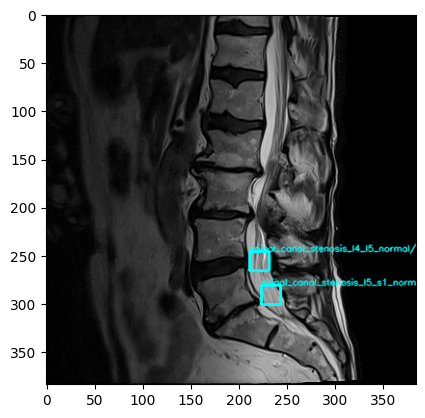

In [24]:
_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H, W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x, y, w, h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x - w / 2)
    x2 = int(x + w / 2)
    y1 = int(y - h / 2)
    y2 = int(y + h / 2)
    label = id2label[_cls]
    
    c = (0, 255, 255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [25]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: spinal_canal_stenosis_l1_l2_normal/mild
1: spinal_canal_stenosis_l1_l2_moderate
2: spinal_canal_stenosis_l1_l2_severe
3: spinal_canal_stenosis_l2_l3_normal/mild
4: spinal_canal_stenosis_l2_l3_moderate
5: spinal_canal_stenosis_l2_l3_severe
6: spinal_canal_stenosis_l3_l4_normal/mild
7: spinal_canal_stenosis_l3_l4_moderate
8: spinal_canal_stenosis_l3_l4_severe
9: spinal_canal_stenosis_l4_l5_normal/mild
10: spinal_canal_stenosis_l4_l5_moderate
11: spinal_canal_stenosis_l4_l5_severe
12: spinal_canal_stenosis_l5_s1_normal/mild
13: spinal_canal_stenosis_l5_s1_moderate
14: spinal_canal_stenosis_l5_s1_severe


In [26]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [27]:
import os
HOME = os.getcwd()

In [28]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!ls -lh {HOME}/weights

total 123M
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [29]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0
train: images/train  
val: images/val 
test: images/val 

names:
    0: spinal_canal_stenosis_l1_l2_normal/mild
    1: spinal_canal_stenosis_l1_l2_moderate
    2: spinal_canal_stenosis_l1_l2_severe
    3: spinal_canal_stenosis_l2_l3_normal/mild
    4: spinal_canal_stenosis_l2_l3_moderate
    5: spinal_canal_stenosis_l2_l3_severe
    6: spinal_canal_stenosis_l3_l4_normal/mild
    7: spinal_canal_stenosis_l3_l4_moderate
    8: spinal_canal_stenosis_l3_l4_severe
    9: spinal_canal_stenosis_l4_l5_normal/mild
    10: spinal_canal_stenosis_l4_l5_moderate
    11: spinal_canal_stenosis_l4_l5_severe
    12: spinal_canal_stenosis_l5_s1_normal/mild
    13: spinal_canal_stenosis_l5_s1_moderate
    14: spinal_canal_stenosis_l5_s1_severe

Writing yolo_scs.yaml


In [30]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

secret_value_0 = 'i said no'
wandb.login(key=secret_value_0)

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
wandb.init(
    project='lsdc_yolov10x',
    group='';'.join(CONDITIONS)
)

wandb: Currently logged in as: lightsource- (lightsource-unk). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240925_071614-kdvxvouc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run serene-moon-8
wandb: ⭐️ View project at https://wandb.ai/lightsource-unk/lsdc_yolov10x
wandb: 🚀 View run at https://wandb.ai/lightsource-unk/lsdc_yolov10x/runs/kdvxvouc


In [32]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10x.pt')
add_wandb_callback(model, enable_model_checkpointing=True)

model.train(
    project='lsdc_yolov10', 
    data='yolo_scs.yaml', 
    epochs=EPOCHS, 
    imgsz=OD_INPUT_SIZE, 
    batch=BATCH_SIZE, 
    optimizer='AdamW',
    seed=52,
    cos_lr=True,
    device=[0, 1],
#     box=2.5,
#     cls=4.5,
#     dfl=2.5,
#     dropout=0.05
)

wandb.finish()

New https://pypi.org/project/ultralytics/8.2.100 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10x.pt, data=yolo_scs.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=384, save=True, save_period=-1, val_period=1, cache=False, device=[0, 1], workers=8, project=lsdc_yolov10, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=52, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]
2024-09-25 07:16:33,928	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-25 07:16:34,797	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-25 07:16:37.898153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 07:16:37.898257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 07:16:38.070251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1    213120  ultralytics.nn.modules.block.SCDown          [320, 640, 3, 2]              
  6                  -1  6   4604160  ultralytics.nn.modules.block.C2fCIB          [640, 640, 6, True]           
  7                  -1  1    417920  ultralytic

2024-09-25 07:16:59.007017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 07:16:59.007090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 07:16:59.008758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir lsdc_yolov10/train', view at http://localhost:6006/


wandb: Currently logged in as: lightsource- (lightsource-unk). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240925_071702-fzf8aa8p
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/lightsource-unk/lsdc_yolov10
wandb: 🚀 View run at https://wandb.ai/lightsource-unk/lsdc_yolov10/runs/fzf8aa8p


Overriding model.yaml nc=80 with nc=15
Transferred 1123/1135 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 74.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold0/labels/train... 2013 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2013/2013 [00:01<00:00, 1132.00it/s]


train: New cache created: /kaggle/working/data_fold0/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val... 509 images, 0 backgrounds, 0 corrupt: 100%|██████████| 509/509 [00:00<00:00, 1199.27it/s]


val: New cache created: /kaggle/working/data_fold0/labels/val.cache
Plotting labels to lsdc_yolov10/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 185 weight(decay=0.0), 198 weight(decay=0.0005), 197 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to lsdc_yolov10/train
Starting training for 100 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      1/100      4.93G      2.777      3.283      1.329      2.578      3.316      1.164         31        384: 100%|██████████| 126/126 [00:45<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


                   all        509       1950      0.241      0.183      0.089     0.0295

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      2/100      5.24G      2.158      1.939      1.053      2.059      2.093     0.9884         48        384: 100%|██████████| 126/126 [00:40<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


                   all        509       1950      0.585      0.153      0.121      0.044

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      3/100      5.24G      2.105      1.744      1.039      2.004      1.876     0.9714         37        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.697      0.212      0.191     0.0824

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      4/100      5.24G      2.037      1.668      1.024      1.959      1.803     0.9632         42        384: 100%|██████████| 126/126 [00:39<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.667      0.177      0.164     0.0526

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      5/100      5.25G      1.993      1.588       1.02      1.916        1.7     0.9624         44        384: 100%|██████████| 126/126 [00:38<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


                   all        509       1950      0.835      0.228      0.255      0.104

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      6/100      5.24G      1.909      1.518     0.9986      1.887      1.636     0.9478         61        384: 100%|██████████| 126/126 [00:39<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.484       0.33      0.286      0.123

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      7/100      5.25G      1.865      1.439     0.9852      1.862      1.522      0.945         38        384: 100%|██████████| 126/126 [00:40<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


                   all        509       1950      0.448      0.382      0.285      0.107

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      8/100      5.24G      1.877      1.444     0.9904      1.827      1.559     0.9432         49        384: 100%|██████████| 126/126 [00:40<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


                   all        509       1950      0.355      0.485       0.38      0.179

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      9/100      5.25G       1.86      1.398     0.9864      1.828      1.519     0.9387         53        384: 100%|██████████| 126/126 [00:42<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


                   all        509       1950      0.668      0.406      0.376      0.179

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     10/100      5.24G      1.803      1.413     0.9803      1.761       1.49     0.9319         37        384: 100%|██████████| 126/126 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


                   all        509       1950       0.52      0.408      0.361       0.14

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     11/100      5.24G      1.837      1.361     0.9776      1.789      1.474     0.9283         36        384: 100%|██████████| 126/126 [00:41<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


                   all        509       1950      0.498      0.422      0.376      0.177

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     12/100      5.24G      1.808      1.292     0.9721       1.74      1.401     0.9225         31        384: 100%|██████████| 126/126 [00:41<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


                   all        509       1950      0.577      0.462      0.423      0.201

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     13/100      5.24G      1.816       1.31     0.9714      1.759       1.42     0.9235         40        384: 100%|██████████| 126/126 [00:40<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.441      0.545      0.415      0.201

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     14/100      5.24G      1.809      1.341     0.9809      1.745      1.441     0.9256         38        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950       0.66      0.404      0.433      0.218

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     15/100      5.24G      1.798      1.327     0.9791      1.718      1.449     0.9221         56        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.454      0.513       0.43      0.213

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     16/100      5.24G      1.785      1.279     0.9764      1.699       1.37     0.9198         35        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.448      0.512      0.446      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     17/100      5.24G      1.791      1.285     0.9734      1.699      1.374     0.9188         40        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.495      0.519      0.461      0.226

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     18/100      5.24G      1.797      1.279     0.9739      1.706       1.38     0.9167         49        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.491      0.478      0.425      0.217

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     19/100      5.24G      1.779      1.277     0.9655      1.681      1.371     0.9097         56        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.656      0.454      0.472      0.241

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     20/100      5.24G       1.72      1.217     0.9553      1.665      1.308     0.9075         43        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.558      0.501      0.484      0.248

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     21/100      5.24G      1.738      1.238     0.9606      1.675       1.36     0.9135         55        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.506      0.514      0.451      0.217

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     22/100      5.24G      1.723       1.24     0.9559      1.654      1.346     0.9082         39        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.617      0.453      0.459      0.224

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     23/100      5.24G      1.749       1.21     0.9615       1.68      1.308     0.9118         35        384: 100%|██████████| 126/126 [00:39<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.618      0.455      0.439      0.216

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     24/100      5.24G      1.719      1.222     0.9569       1.66      1.314     0.9102         48        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950       0.51      0.513      0.464      0.222

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     25/100      5.24G      1.706      1.183     0.9599      1.637      1.266      0.915         29        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.461      0.552      0.471       0.23

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     26/100      5.24G      1.691      1.175     0.9571      1.614      1.275     0.9056         44        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.496        0.5      0.449      0.206

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     27/100      5.24G      1.725      1.182     0.9553      1.658      1.288     0.9091         32        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950       0.69      0.447      0.464      0.226

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     28/100      5.24G      1.729      1.193     0.9616      1.689      1.269      0.913         34        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.494      0.575      0.485      0.237

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     29/100      5.24G      1.706      1.202     0.9605      1.626      1.311     0.9085         26        384: 100%|██████████| 126/126 [00:39<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.656      0.458      0.466      0.231

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     30/100      5.24G      1.682      1.207     0.9496      1.628      1.303     0.9083         30        384: 100%|██████████| 126/126 [00:39<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950       0.62      0.446      0.453      0.219

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     31/100      5.24G      1.723      1.193     0.9696      1.661      1.286     0.9206         40        384: 100%|██████████| 126/126 [00:39<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.583      0.555      0.505      0.232

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     32/100      5.24G      1.653      1.154     0.9457      1.574      1.269        0.9         37        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.454      0.596      0.502      0.244

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     33/100      5.24G      1.698      1.156     0.9499      1.629      1.241     0.9036         26        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.585      0.536      0.477       0.24

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     34/100      5.24G      1.691      1.161     0.9494      1.647      1.234      0.905          9        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.466      0.524      0.511       0.25

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     35/100      5.24G      1.668      1.151     0.9477      1.597      1.237     0.8998         27        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.687      0.433      0.504      0.261

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     36/100      5.24G      1.657      1.152     0.9545      1.626      1.199      0.912         36        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.528      0.523      0.476      0.244

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     37/100      5.24G      1.656      1.133     0.9498      1.597       1.23     0.9053         24        384: 100%|██████████| 126/126 [00:39<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.488      0.584      0.498      0.258

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     38/100      5.24G      1.636      1.116     0.9431      1.567      1.195      0.899         23        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


                   all        509       1950      0.398      0.568      0.472      0.236

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     39/100      5.24G      1.667      1.126     0.9483      1.596      1.207     0.9022         44        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950       0.56      0.506      0.478      0.248

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     40/100      5.24G      1.648       1.11     0.9458      1.584      1.205     0.9007         73        384: 100%|██████████| 126/126 [00:39<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.496      0.667        0.5      0.254

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     41/100      5.24G      1.633      1.107     0.9429      1.554      1.206     0.8975         51        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.459      0.645      0.491      0.251

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     42/100      5.24G      1.635      1.126     0.9441      1.567      1.218        0.9         59        384: 100%|██████████| 126/126 [00:39<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950       0.51      0.571      0.489      0.246

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     43/100      5.24G      1.608      1.124     0.9382      1.533      1.217     0.8947         31        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.589      0.544      0.526      0.262

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     44/100      5.24G      1.641      1.122     0.9399      1.602      1.172     0.8985         40        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.434      0.616      0.533      0.266

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     45/100      5.24G      1.639      1.081     0.9474      1.581      1.163     0.9031         24        384: 100%|██████████| 126/126 [00:39<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.464      0.611      0.549      0.272

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     46/100      5.24G      1.617      1.091     0.9423      1.554      1.184     0.8971         32        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.403      0.663      0.537      0.248

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     47/100      5.24G      1.613      1.095     0.9462      1.551      1.185     0.9007         42        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950       0.46      0.589      0.486      0.259

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     48/100      5.24G      1.615      1.079     0.9434      1.533       1.19     0.9006         24        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.372      0.642      0.489      0.245

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     49/100      5.24G      1.622        1.1     0.9384      1.554      1.181     0.8928         40        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.497      0.496      0.462      0.243

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     50/100      5.24G       1.61      1.054     0.9339      1.549       1.15      0.895         38        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.505      0.648      0.541      0.275

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     51/100      5.24G       1.63      1.101     0.9427      1.546      1.179      0.896         34        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


                   all        509       1950      0.448      0.667      0.533      0.266

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     52/100      5.24G      1.595      1.063     0.9336      1.529       1.15     0.8924         29        384: 100%|██████████| 126/126 [00:39<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


                   all        509       1950      0.523      0.578      0.484      0.255

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     53/100      5.24G       1.59       1.07     0.9404      1.537      1.149     0.8955         27        384: 100%|██████████| 126/126 [00:40<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.639      0.521      0.524      0.256

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     54/100      5.24G       1.58      1.056     0.9345      1.535      1.135     0.8928         33        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.562      0.578      0.511      0.255

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     55/100      5.24G      1.611      1.077     0.9383      1.565      1.144     0.8977         48        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.535      0.611       0.55      0.274

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     56/100      5.24G      1.587      1.058     0.9342      1.543      1.145     0.8968         35        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.468      0.623      0.551      0.277

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     57/100      5.24G      1.546      1.057     0.9274      1.497      1.152     0.8869         41        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.454      0.658       0.54      0.279

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     58/100      5.24G      1.571      1.041     0.9351      1.514       1.11     0.8938         48        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.519      0.616      0.521      0.264

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     59/100      5.24G      1.587      1.038     0.9411      1.524      1.107     0.8976         36        384: 100%|██████████| 126/126 [00:39<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.516      0.624      0.521      0.262

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     60/100      5.24G      1.575       1.02     0.9333      1.496      1.132      0.888         33        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.578      0.553      0.537      0.268

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     61/100      5.24G      1.564      1.041     0.9229      1.503      1.107     0.8828         52        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.556      0.582      0.505      0.258

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     62/100      5.24G      1.568      1.018      0.927      1.507      1.077     0.8878         33        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.465      0.639      0.521      0.259

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     63/100      5.24G      1.562      1.028     0.9321      1.511       1.09     0.8913         41        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.512      0.598      0.518      0.258

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     64/100      5.24G      1.555      1.022     0.9287      1.501      1.085     0.8883         37        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.445      0.621      0.515      0.266

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     65/100      5.24G      1.535      1.001     0.9273      1.486      1.072      0.887         35        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.475      0.646      0.554      0.274

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     66/100      5.24G      1.532     0.9959     0.9257      1.483      1.056     0.8857         36        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.601      0.606      0.551      0.274

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     67/100      5.25G      1.537     0.9769     0.9209      1.475      1.065     0.8814         28        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.472      0.648      0.529      0.258

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     68/100      5.24G      1.518     0.9996     0.9206      1.475      1.072     0.8838         36        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950       0.53      0.576      0.564      0.287

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     69/100      5.24G       1.57      1.007     0.9308      1.506      1.053     0.8898         29        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.467      0.661      0.532      0.273

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     70/100      5.24G      1.536      1.015      0.926       1.48      1.072     0.8856         36        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


                   all        509       1950      0.437      0.646      0.546      0.286

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     71/100      5.24G      1.523     0.9776      0.925      1.492      1.034      0.888         48        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.517       0.61      0.545      0.289

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     72/100      5.24G       1.53      0.969     0.9216      1.484      1.026      0.883         41        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.452      0.655      0.548      0.287

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     73/100      5.24G      1.524     0.9601     0.9239      1.472      1.024     0.8852         32        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.524      0.574      0.539      0.275

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     74/100      5.24G      1.525     0.9726     0.9184      1.482      1.007     0.8847         54        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.397      0.637      0.538      0.278

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     75/100      5.24G      1.534     0.9486      0.928      1.493      1.013     0.8902         39        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.477      0.631       0.54       0.27

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     76/100      5.24G      1.505     0.9525     0.9187      1.468      1.007     0.8847         24        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.469      0.627       0.54      0.287

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     77/100      5.24G      1.488     0.9332     0.9212      1.446      1.016     0.8859         45        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.541      0.596      0.553      0.293

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     78/100      5.24G       1.51     0.9641     0.9232      1.474      1.041     0.8861         47        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.486      0.589      0.558      0.293

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     79/100      5.24G      1.499     0.9622      0.915      1.451      1.031     0.8812         48        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


                   all        509       1950       0.42      0.648      0.548      0.284

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     80/100      5.24G      1.541     0.9594     0.9326      1.477      1.032     0.8898         23        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.478      0.649      0.531      0.274

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     81/100      5.24G        1.5     0.9488      0.917      1.452          1     0.8805         31        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.446      0.677      0.533       0.28

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     82/100      5.24G      1.487     0.9386     0.9161      1.463     0.9806     0.8824         63        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.447      0.591      0.533      0.273

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     83/100      5.24G      1.499     0.9499     0.9229      1.452      1.001     0.8865         39        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.495      0.599      0.538      0.278

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     84/100      5.24G      1.486     0.9343     0.9158       1.46      1.001     0.8804         39        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.476      0.626      0.545      0.282

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     85/100      5.24G      1.491     0.9386     0.9135      1.443      1.002     0.8785         28        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.579      0.524      0.538      0.273

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     86/100      5.24G      1.504     0.9231     0.9182      1.464       0.98     0.8819         46        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.484      0.589      0.544      0.285

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     87/100      5.24G      1.496     0.9252     0.9176      1.443     0.9913     0.8779         27        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.498      0.609       0.54      0.282

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     88/100      5.24G      1.494     0.9522     0.9256       1.44      1.008     0.8857         56        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.475      0.641      0.528      0.272

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     89/100      5.24G      1.481     0.9145     0.9166      1.444     0.9646     0.8808         36        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.483        0.6      0.521       0.27

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     90/100      5.24G      1.473     0.8913     0.9178      1.433     0.9539     0.8823         30        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


                   all        509       1950      0.433      0.618      0.515      0.266
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     91/100      5.24G      1.511     0.9041     0.9551      1.461     0.9301     0.9137         29        384: 100%|██████████| 126/126 [00:39<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.469      0.567      0.528      0.276

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     92/100      5.24G       1.47     0.8998     0.9502      1.412      0.943     0.9081         29        384: 100%|██████████| 126/126 [00:39<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.462      0.587      0.526      0.277

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     93/100      5.24G      1.437     0.8884     0.9359       1.38     0.9328     0.8943         22        384: 100%|██████████| 126/126 [00:38<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all        509       1950      0.445      0.587       0.53      0.281

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     94/100      5.24G      1.438      0.873     0.9424      1.369     0.9287     0.9001         24        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.485      0.545      0.525      0.275

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     95/100      5.24G       1.44     0.8622     0.9453      1.389     0.9064      0.907         25        384: 100%|██████████| 126/126 [00:38<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.512      0.525      0.526      0.276

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     96/100      5.24G      1.459     0.8625     0.9465      1.388     0.9075     0.9032         26        384: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.454      0.599      0.531      0.281

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     97/100      5.24G      1.444     0.8753     0.9421      1.405     0.8918     0.9035         20        384: 100%|██████████| 126/126 [00:39<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.458      0.597      0.533      0.285

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     98/100      5.24G      1.436     0.8712      0.944      1.394     0.9013     0.9053         30        384: 100%|██████████| 126/126 [00:39<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.472      0.584      0.531      0.283

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     99/100      5.24G      1.438     0.8668     0.9431      1.393     0.8911     0.9042         21        384: 100%|██████████| 126/126 [00:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.465       0.61      0.529      0.281

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


    100/100      5.24G      1.424      0.876      0.937       1.38     0.9136     0.8994         24        384: 100%|██████████| 126/126 [00:39<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


                   all        509       1950      0.485      0.581      0.529      0.281

100 epochs completed in 1.610 hours.
Optimizer stripped from lsdc_yolov10/train/weights/last.pt, 64.1MB
Optimizer stripped from lsdc_yolov10/train/weights/best.pt, 64.1MB

Validating lsdc_yolov10/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv10x summary (fused): 503 layers, 31612970 parameters, 0 gradients, 169.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


                   all        509       1950      0.486      0.589      0.558      0.293
spinal_canal_stenosis_l1_l2_normal/mild        509        369      0.689      0.927      0.816      0.399
spinal_canal_stenosis_l1_l2_moderate        509          9       0.56      0.667      0.573      0.283
spinal_canal_stenosis_l1_l2_severe        509          2          0          0      0.249       0.12
spinal_canal_stenosis_l2_l3_normal/mild        509        350      0.728        0.9      0.816      0.408
spinal_canal_stenosis_l2_l3_moderate        509         27      0.261      0.296      0.316      0.189
spinal_canal_stenosis_l2_l3_severe        509          8      0.288        0.5      0.312       0.19
spinal_canal_stenosis_l3_l4_normal/mild        509        325      0.747      0.892      0.868      0.454
spinal_canal_stenosis_l3_l4_moderate        509         43      0.369      0.488      0.442      0.226
spinal_canal_stenosis_l3_l4_severe        509         27      0.516       0.63    

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                  lr/pg1 ▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:                  lr/pg2 ▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:        metrics/mAP50(B) ▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇██▇█▇█▇▇▇█████████▇████
wandb:     metrics/mAP50-95(B) ▁▂▃▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇████▇██▇█▇██
wandb:    metrics/precision(B) ▁█▅▃▅▄▄▅▅▇▅▅▆▄▅▆▄▄▃▅▄▆▄▅▆▄▅▄▄▃▆▄▄▅▅▅▄▅▄▅
wandb:       metrics/recall(B) ▁▁▃▅▄▆▆▅▆��▆▇▆▆▆▆█▇█▆█▇▇▇▇▇████▇█▇▇▇▇▇▆▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:            train/box_om █▅▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
wandb:            train/box_oo █▅▄▄▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
wandb:            train/cls_om █▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            train/cls_oo █▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁

spinal_canal_stenosis_l1_l2_normal/mild
spinal_canal_stenosis_l2_l3_normal/mild
spinal_canal_stenosis_l3_l4_normal/mild
spinal_canal_stenosis_l4_l5_moderate
spinal_canal_stenosis_l5_s1_normal/mild


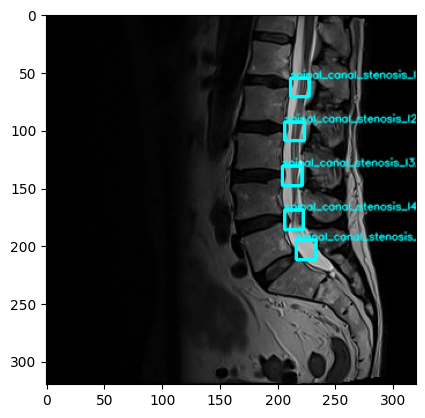

In [33]:
_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name + '.jpg')

im = plt.imread(path).copy()
H, W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name + '.txt')).reshape(-1, 5)

for _cls, x, y, w, h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x - w / 2)
    x2 = int(x + w / 2)
    y1 = int(y - h / 2)
    y2 = int(y + h / 2)
    label = id2label[_cls]
    print(label)
    
    c = (0, 255, 255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [34]:
model = YOLOv10(glob.glob('lsdc_yolov10/*/weights/best.pt')[0])

out = model.predict([path], save=True, conf=0.2)

wandb.finish()


0: 384x384 1 spinal_canal_stenosis_l1_l2_normal/mild, 1 spinal_canal_stenosis_l2_l3_normal/mild, 2 spinal_canal_stenosis_l3_l4_normal/milds, 1 spinal_canal_stenosis_l4_l5_moderate, 1 spinal_canal_stenosis_l5_s1_normal/mild, 36.2ms
Speed: 3.1ms preprocess, 36.2ms inference, 58.3ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


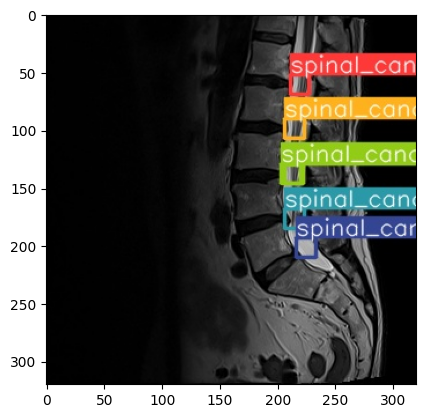

In [35]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)